In [62]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import normalize

from matplotlib import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
%matplotlib inline
"""
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html
http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html#sphx-glr-auto-examples-decomposition-plot-ica-vs-pca-py
"""
N = 1000
alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)
z = np.ones(N)

RI_pres = np.random.rand(D, N)
RI_pres = np.where(RI_pres>0.5, 1, -1)

RI_past = np.random.rand(D, N)
RI_past = np.where(RI_past>0.5, 1, -1)

def read_csv(filepath):
    category2word = {}
    category2freqdist = {}
    key = 0
    present, past, weights = [], [], []
    num_words = 0
    with open(filepath, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] == "#":
                category2word[key] = [present, past]
                
                weights = np.asarray(weights)
                # true probability is weights/np.sum(weights,axis=0). 
                # 1 - is to emphasize smaller freqs. idk 
                weights = 1-weights/np.sum(weights,axis=0)
                # force sum to 1
                weights = weights/np.sum(weights,axis=0)

                category2freqdist[key] = weights
                
                #category2freqdist[key] = normalize(np.array(weights), axis=1)
                key += 1;
                present, past, weights = [], [], []
                
            else:
                present.append(row[0])
                past.append(row[1])
                weights.append(float(row[2]))
            num_words += 1
    return category2word, category2freqdist, num_words

def ngram_encode(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)     
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6,
                       color=color)

In [63]:
category2word, category2freqdist, num_words = read_csv("data/cleaned/irregular_verbs_final_categorize.csv")

In [64]:
#category2word, category2freqdist
for k, v in category2freqdist.items():
    print v
    print v.dot(v.T)
    print np.sum(v,axis=0)
    print np.max(v)

[ 0.10810811  0.10810811  0.10810811  0.10810811  0.10810811  0.10810811
  0.10810811  0.12162162  0.12162162]
0.111395178963
1.0
0.121621621622
[ 0.17647059  0.17647059  0.17647059  0.23529412  0.23529412]
0.204152249135
1.0
0.235294117647
[ 0.05800866  0.06233766  0.06233766  0.06233766  0.06233766  0.06233766
  0.06233766  0.06233766  0.06233766  0.06233766  0.06233766  0.06233766
  0.06233766  0.06233766  0.06580087  0.06580087]
0.0625423061787
1.0
0.0658008658009
[ 0.11180124  0.11180124  0.12732919  0.12732919  0.12732919  0.12732919
  0.12732919  0.13975155]
0.125593148412
1.0
0.139751552795
[ 0.04299584  0.04530744  0.04530744  0.04530744  0.04530744  0.04530744
  0.04530744  0.04530744  0.04530744  0.04530744  0.04530744  0.04530744
  0.04530744  0.04530744  0.04530744  0.04530744  0.04530744  0.04530744
  0.04530744  0.04715673  0.04715673  0.04715673]
0.0454696724575
1.0
0.0471567267684
[ 0.25  0.25  0.25  0.25]
0.25
1.0
0.25
[ 0.14444444  0.14444444  0.14444444  0.18888889 

In [94]:
def sample(X, category_size, freqdist, mu, sigma):
    num_samples = category_size - X.shape[0]
    X_filled = np.zeros((category_size, N))
    X_filled[:X.shape[0]] = X
    X_filled[X.shape[0]:] = X[np.random.choice(X.shape[0], num_samples, freqdist)] + \
    np.random.normal(mu, sigma, (num_samples, N))
    return X_filled

def gen_diffs(present, past, RI_pres, RI_past, ngram_length):
    X = np.zeros((len(past), N))
    for i in range(X.shape[0]):
        X[i] = (ngram_encode(past[i], RI_past, ngram_length) 
                        - ngram_encode(present[i], RI_pres, ngram_length))
        
    #return normalize(X,axis=0)
    return X

('red', ['built', 'sent', 'spent', 'bent', 'lent'])
('blue', ['felt', 'dealt', 'did', 'fled', 'told', 'sold', 'heard', 'kept', 'left', 'slept', 'lost', 'meant', 'said', 'swept', 'crept', 'wept'])
ngram_length 3


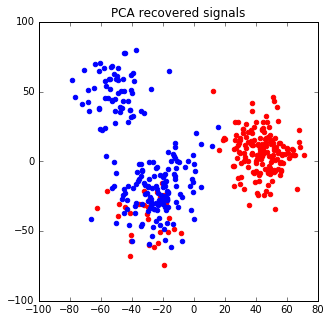

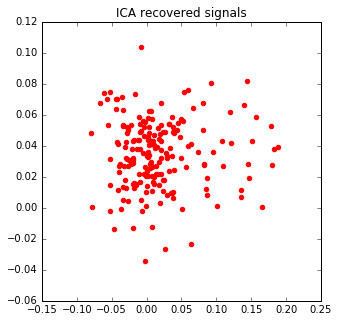

In [99]:
# add more data points by resampling + noise
# make the categories equal size
available_colors = ['green', 'red', 'blue', 'yellow', 'black']
# looking only at category 0, 1
selected_categories = [1, 2]
category_size = 200
ngram_lengths = [3]
mu = 0
sigma = 10

num_diffs = 0

for c in selected_categories:
    print (available_colors[c],category2word[c][1]) 
    
X = np.zeros((category_size*len(selected_categories), N))

for ngram_length in ngram_lengths:
    print "ngram_length %d" % ngram_length
    # Generate observations
    cat_index = 0
    for c in selected_categories:
        num_subwords = len(category2word[c][0])
        
        X_cat = gen_diffs(category2word[c][0], category2word[c][1], RI_past, RI_past, ngram_length)
        X_cat_filled = sample(X_cat, category_size, category2freqdist, mu, sigma)
        X[cat_index*category_size:(cat_index+1)*category_size] = X_cat_filled
        cat_index += 1

    pca = PCA(n_components=3)
    S_pca_ = pca.fit(X).transform(X)

    ica = FastICA(n_components=3)
    S_ica_ = ica.fit(X).transform(X)
    
    axis_list = [pca.components_.T, ica.mixing_]
    
    pc1 = 0
    pc2 = 1
    
    
    # 2d
    cat_index = 0
    fig, ax = plt.subplots(figsize=(4,3))
    for c in selected_categories:
        ax.scatter(S_pca_[cat_index*category_size:(cat_index+1)*category_size,pc1], \
                   S_pca_[cat_index*category_size:(cat_index+1)*category_size,pc2], color=available_colors[c])
        cat_index += 1
    plt.title('PCA recovered signals')
    plt.show()
    fname =  ('figures/pca_color-ngram_length=' + str(ngram_length) + 'pc1-pc2-N=' + str(N) ) 
          + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)
    
    
    ic1 = 0
    ic2 = 1
    fig, ax = plt.subplots(figsize=(4,3))
    i = 0
    for c in selected_categories:
        ax.scatter(S_ica_[c*category_size:(c+1)*category_size,ic1], \
                   S_ica_[c*category_size:(c+1)*category_size,ic2], color=available_colors[c])

    plt.title('ICA recovered signals')
    plt.show()
    fname =  ('figures/ica_color-ngram_length=' + str(ngram_length) + 'ic1-ic2-N=' + str(N) ) 
          + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)

In [68]:
available_colors = ['green', 'red', 'blue', 'yellow', 'black']
# looking only at category 0, 1
selected_categories = [0, 1]
num_diffs = 0
past = []
for c in selected_categories:
    num_diffs += len(category2word[c][0])
    past += category2word[c][1]
data_matrix = np.zeros((num_diffs, N))
ngram_lengths = [2, 3, 4]

ngram_length 2


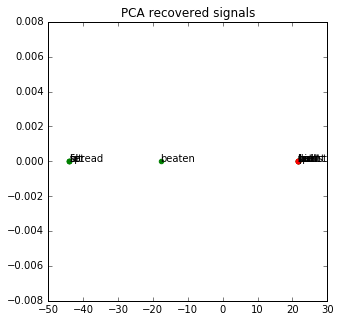

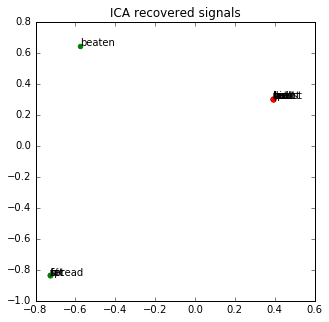

ngram_length 3


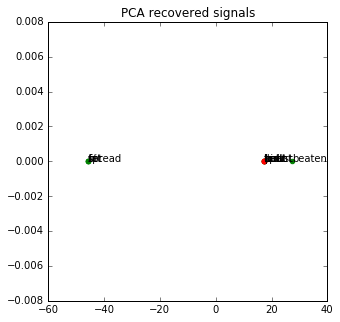

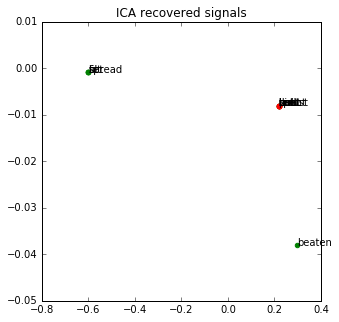

ngram_length 4


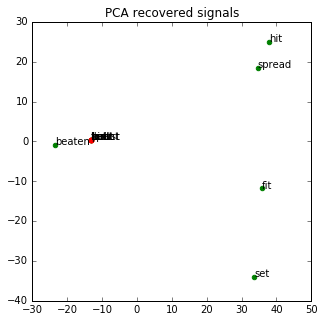

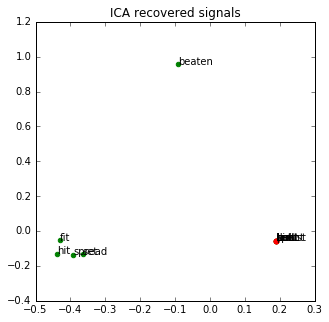

In [70]:
for ngram_length in ngram_lengths:
    print "ngram_length %d" % ngram_length
    # Generate observations
    for c in selected_categories:
        num_subwords = len(category2word[c][0])
        for i in range(num_subwords):
            data_matrix[i] = (ngram_encode(category2word[c][1][i], RI_past, ngram_length) 
                              - ngram_encode(category2word[c][0][i], RI_past, ngram_length))

    X = data_matrix

    pca = PCA(n_components=3)
    S_pca_ = pca.fit(X).transform(X)

    ica = FastICA(n_components=3)
    S_ica_ = ica.fit(X).transform(X)  # Estimate the sources
    
    axis_list = [pca.components_.T, ica.mixing_]
    
    pc1 = 0
    pc2 = 2
    
    # 2d
    fig, ax = plt.subplots(figsize=(4,3))
    i = 0
    for c in selected_categories:
        for txt in category2word[c][1]:
            ax.annotate(txt, [S_pca_[i][pc1], S_pca_[i][pc2]])
            ax.scatter(S_pca_[i][pc1], S_pca_[i][pc2], color=available_colors[c])
            i += 1
    plt.title('PCA recovered signals')
    plt.show()
    fname =  ('figures/pca_color-words-pc1-pc2-N=' + str(N) ) 
          + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)
    
    ic1 = 0
    ic2 = 1
    fig, ax = plt.subplots(figsize=(4,3))
    i = 0
    for c in selected_categories:
        for txt in category2word[c][1]:
            ax.annotate(txt, [S_ica_[i][ic1], S_ica_[i][ic2]])
            ax.scatter(S_ica_[i][ic1], S_ica_[i][ic2], color=available_colors[c])
            i += 1
    plt.title('ICA recovered signals')
    plt.show()
    fname =  ('figures/pca_color-words-pc1-pc2-N=' + str(N) ) 
          + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)

In [ ]:
# add more data points by taking average + noise iteratively
# make the categories equal size